In [7]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Concatenate, TimeDistributed, RepeatVector
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# 데이터 불러오기
df = pd.read_csv('../../Data/using/dt_2.6/ByAstar_dt_2.6_1016.csv')

df = df.dropna(subset=['combination'])

# 데이터셋 분리: train_set 8 : test_set 2
train_df, test_df = train_test_split(df, shuffle=True, test_size=0.2)
# train_set을 다시 8:2로 나눠서 train_set과 validation_set을 만듦
train_df, val_df = train_test_split(train_df, shuffle=True, test_size=0.2)
# random_state=42

# 모든 시퀀스의 길이 중에서 최대 길이를 구하기
all_sequences = [eval(str(seq)) for seq in df['combination'].values]
max_seq_length = max([len(seq) for seq in all_sequences])

# 각 데이터셋에서 theta, phi, sequence 추출하고 reshape 적용
theta_train = train_df['Theta'].values.reshape(-1, 1)
phi_train = train_df['Phi'].values.reshape(-1, 1)
sequence_train = pad_sequences(train_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')

theta_val = val_df['Theta'].values.reshape(-1, 1)
phi_val = val_df['Phi'].values.reshape(-1, 1)
sequence_val = pad_sequences(val_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')

theta_test = test_df['Theta'].values.reshape(-1, 1)
phi_test = test_df['Phi'].values.reshape(-1, 1)
sequence_test = pad_sequences(test_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')


In [8]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 모델 정의
theta_input = Input(shape=(1,), name='theta_input')
phi_input = Input(shape=(1,), name='phi_input')

# theta와 phi를 Concatenate
merged = Concatenate()([theta_input, phi_input])

# 시퀀스를 예측하기 위한 GRU 레이어
repeated_vector = RepeatVector(max_seq_length)(merged)  # max_sequence_length는 시퀀스의 최대 길이

rnn_layer = GRU(256, return_sequences=True, name='rnn_layer')(repeated_vector)

output = TimeDistributed(Dense(5, activation='softmax'), name='output_layer')(rnn_layer)

model = Model(inputs=[theta_input, phi_input], outputs=output)

# 컴파일 및 훈련
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

history = model.fit([theta_train, phi_train], np.expand_dims(sequence_train, -1), 
                    validation_data=([theta_val, phi_val], np.expand_dims(sequence_val, -1)), epochs=500, batch_size=64,
                    callbacks=[early_stopping])

# 검증
loss, accuracy = model.evaluate([theta_test, phi_test], np.expand_dims(sequence_test, -1))
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/500
296/296 [==============================] - 23s 74ms/step - loss: 0.9373 - accuracy: 0.5718 - val_loss: 0.8264 - val_accuracy: 0.5992
Epoch 2/500
296/296 [==============================] - 21s 72ms/step - loss: 0.4958 - accuracy: 0.8067 - val_loss: 0.3830 - val_accuracy: 0.8566
Epoch 3/500
296/296 [==============================] - 21s 72ms/step - loss: 0.3396 - accuracy: 0.8735 - val_loss: 0.3395 - val_accuracy: 0.8721
Epoch 4/500
296/296 [==============================] - 21s 72ms/step - loss: 0.3268 - accuracy: 0.8760 - val_loss: 0.2900 - val_accuracy: 0.8862
Epoch 5/500
296/296 [==============================] - 21s 72ms/step - loss: 0.3097 - accuracy: 0.8817 - val_loss: 0.2648 - val_accuracy: 0.8986
Epoch 6/500
296/296 [==============================] - 21s 72ms/step - loss: 0.3029 - accuracy: 0.8839 - val_loss: 0.2844 - val_accuracy: 0.8880
Epoch 7/500
296/296 [==============================] - 21s 72ms/step - loss: 0.2856 - accuracy: 0.8893 - val_loss: 0.3096 - val_ac

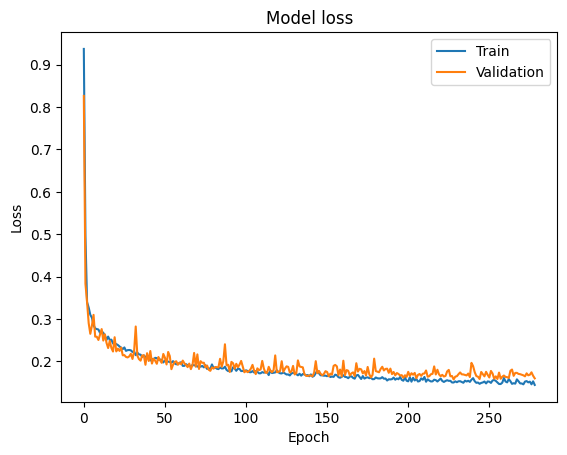

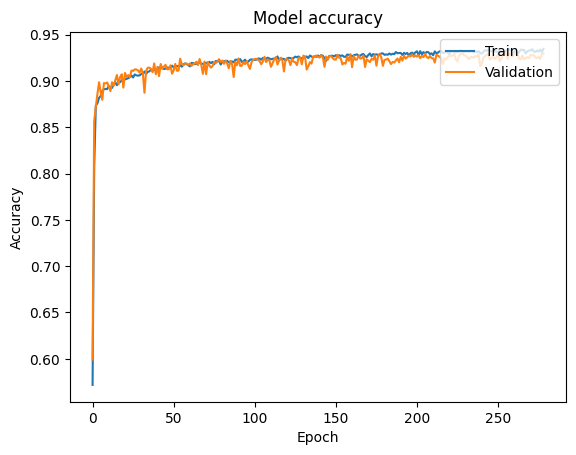

/home/yeojung/.local/lib/python3.10/site-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['sequence_input'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


185/185 [==============================] - 4s 22ms/step - loss: 0.1639 - accuracy: 0.9258
Test Accuracy: 92.58
Test Loss: 16.39


In [9]:
def plot_history(history):
         # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        # plt.axis([45, 70, 0, 0.01])
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

        # Plot training & validation accuracy values
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        # plt.axis([45, 60, 0.999, 1.0])
        plt.legend(['Train', 'Validation'], loc='lower right')
        plt.show()

def evaluate(model, theta, phi, sequence):
    loss, acc = model.evaluate({'theta_input': theta, 'phi_input': phi, 'sequence_input': sequence}, np.expand_dims(sequence, -1))
    print("Test Accuracy: {:.2f}".format(acc*100))
    print("Test Loss: {:.2f}".format(loss*100))

# 결과 그래프 그리기
plot_history(history)

# 모델 성능 평가
evaluate(model, theta_test, phi_test, sequence_test)